 TRAINING: Q-LEARNING vs DOUBLE Q-LEARNING
 25x25 Grid | 3000 Episodes | Goal +1000 | Enemy -200
Running Q-Learning...
 Episode 0
 Episode 1000
 Episode 2000

Running Double Q-Learning...
 Episode 0
 Episode 1000
 Episode 2000

 FINAL BEHAVIOR METRICS COMPARISON
Metric               | Q-Learning   | Double Q    
--------------------------------------------------
Wall Collisions      | 29753        | 29370       
Enemy Collisions     | 891          | 854         
Enemy Avoidances     | 12238        | 11633       
Teleport Uses        | 1520         | 1532        
--------------------------------------------------

Generating Analysis Plots...


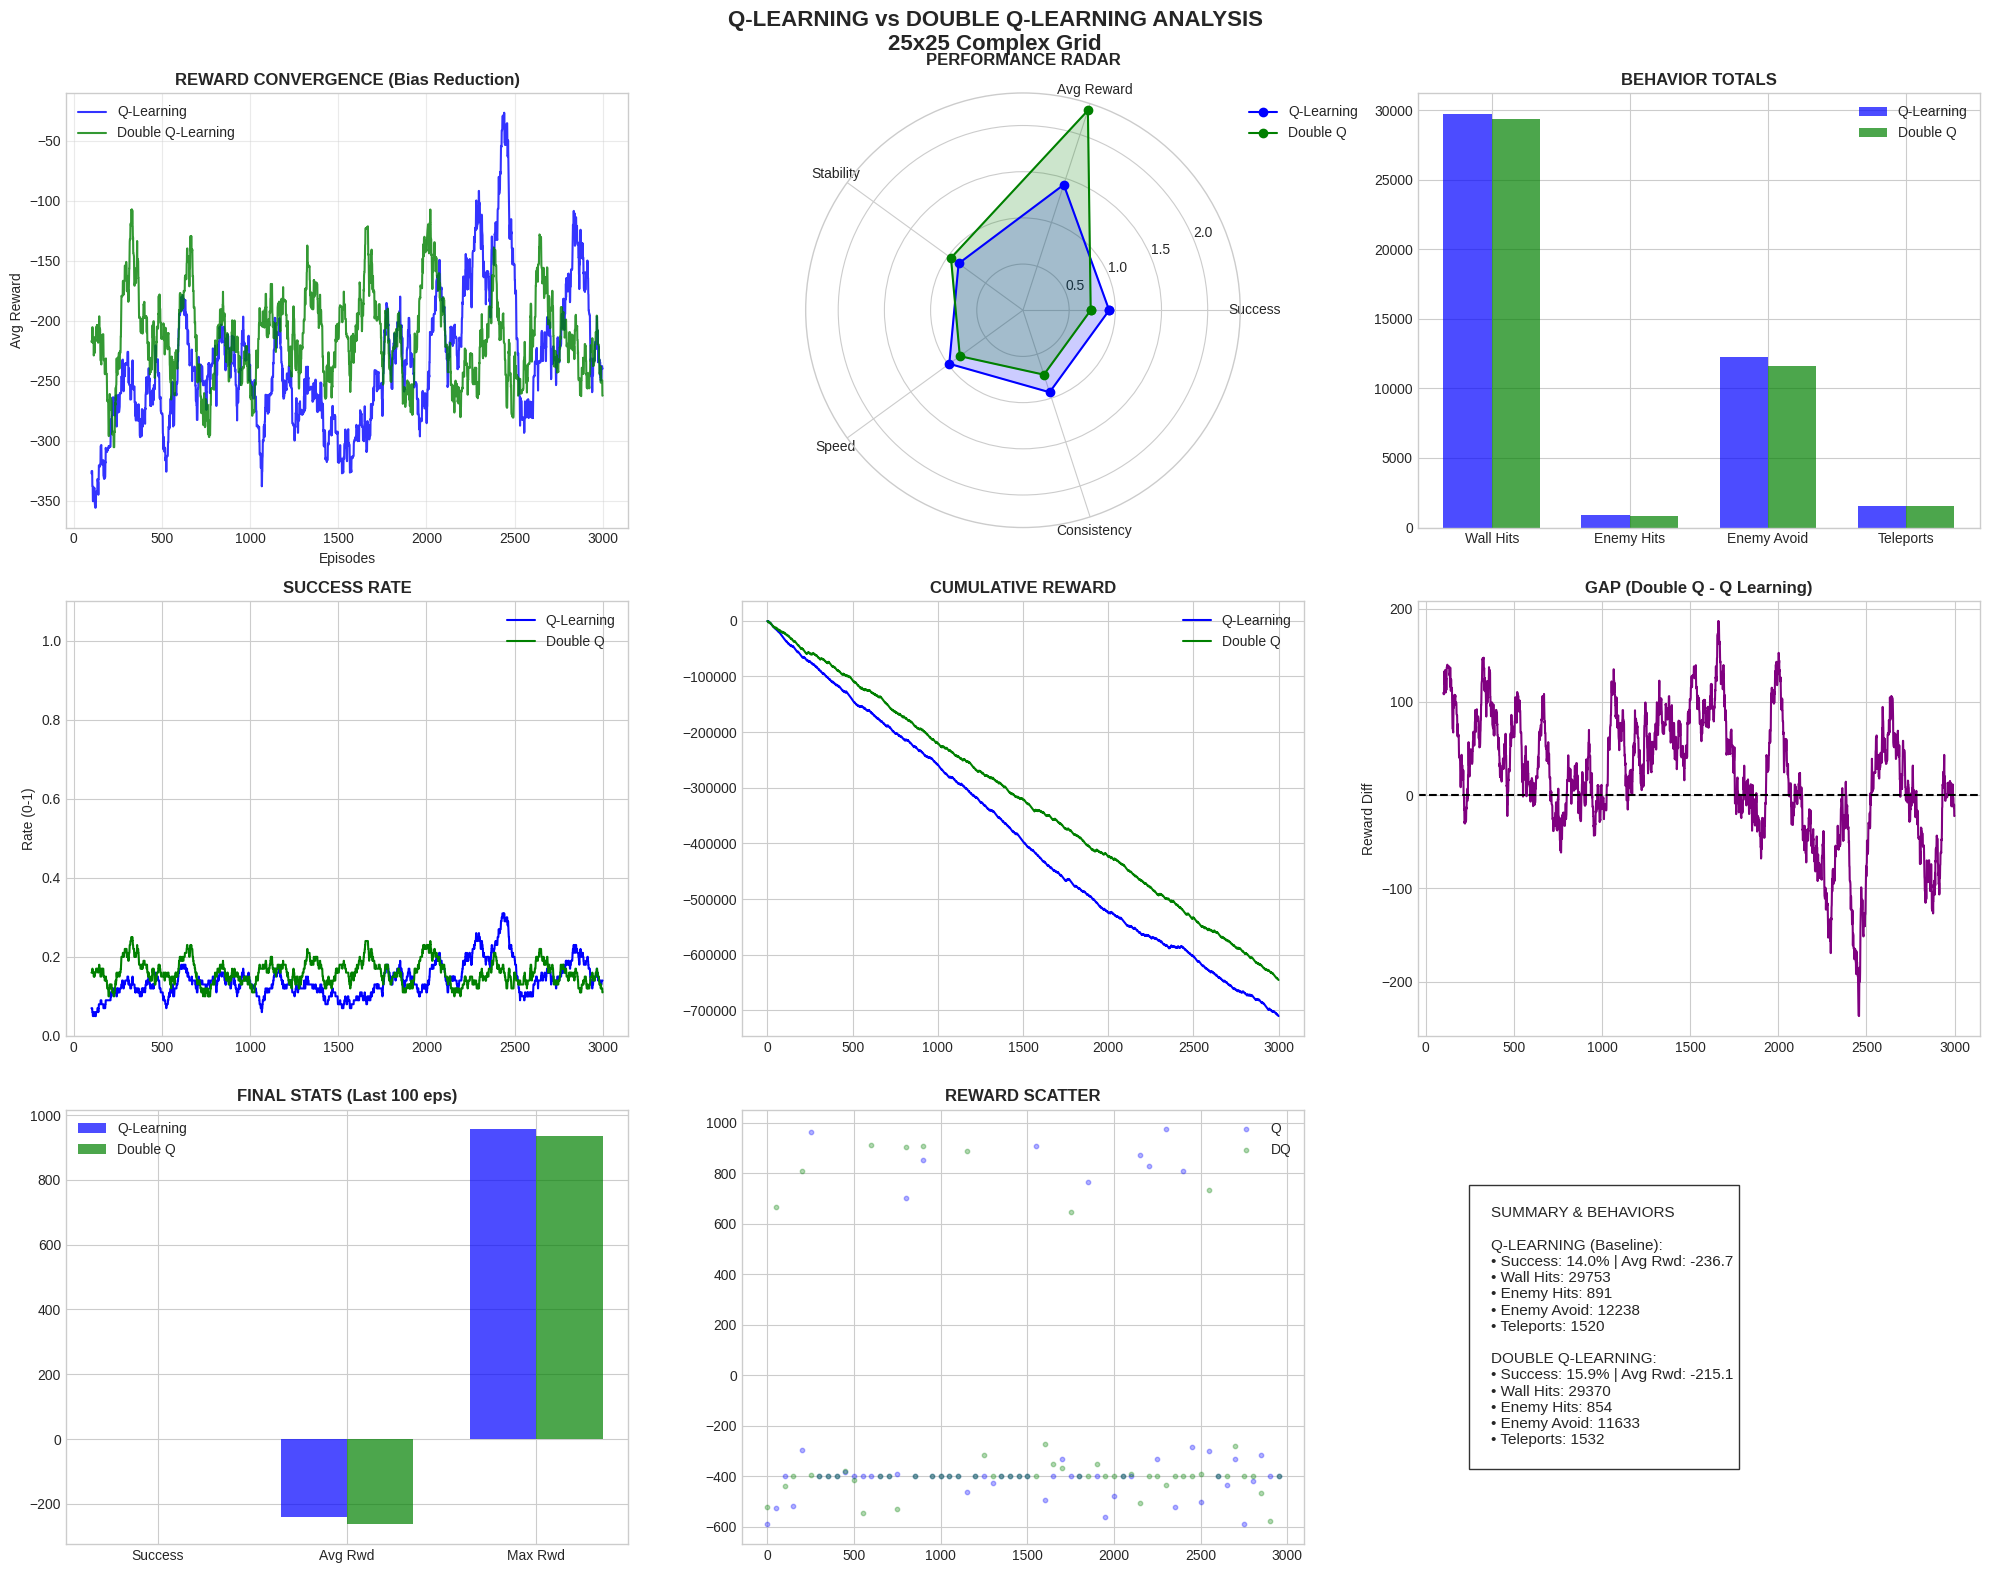

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats

# --- 1. ENVIRONMENT SETUP (Same as provided) ---
class SimpleGridEnv25_Complex:
    def __init__(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self.size = 25
        self.center = (12, 12)
        self.goal = self.center
        self.teleporters = {
            (0, 12): (0.4, 0.3, 0.3),
            (12, 0): (0.2, 0.5, 0.3),
            (24, 12): (0.1, 0.2, 0.7),
        }
        self.action_transitions = {
            0: [('up', 1)], 1: [('down', 1)],
            2: [('left', 1)], 3: [('right',1)],
        }
        self.inner_wall_radius = 4
        self.outer_wall_radius = 8
        self.enemy_radii = [3, 5, 7]
        self.enemy_paths = [self._diamond_path(r) for r in self.enemy_radii]
        self.walls = set()
        self._build_wall_rings_with_cardinal_holes()
        self.reset()

    def _diamond_path(self, radius):
        cx, cy = self.center
        pts = []
        for i in range(radius + 1): pts.append((cx + i, cy + (radius - i)))
        for i in range(1, radius + 1): pts.append((cx + (radius - i), cy - i))
        for i in range(1, radius + 1): pts.append((cx - i, cy - (radius - i)))
        for i in range(1, radius + 1): pts.append((cx - (radius - i), cy + i))
        return pts

    def _diamond_coords(self, r):
        cx, cy = self.center
        coords = []
        for x in range(self.size):
            for y in range(self.size):
                if abs(x - cx) + abs(y - cy) == r: coords.append((x, y))
        return coords

    def _build_wall_rings_with_cardinal_holes(self):
        cx, cy = self.center
        inner = set(self._diamond_coords(self.inner_wall_radius))
        outer = set(self._diamond_coords(self.outer_wall_radius))
        holes = [
            (cx, cy + self.inner_wall_radius), (cx + self.inner_wall_radius, cy),
            (cx, cy - self.inner_wall_radius), (cx - self.inner_wall_radius, cy),
            (cx, cy + self.outer_wall_radius), (cx + self.outer_wall_radius, cy),
            (cx, cy - self.outer_wall_radius), (cx - self.outer_wall_radius, cy)
        ]
        for h in holes:
            inner.discard(h)
            outer.discard(h)
        self.walls = inner.union(outer)
        for t in self.teleporters.keys(): self.walls.discard(t)
        self.walls.discard(self.goal)

    def reset(self):
        corners = [(0, 0), (0, self.size - 1), (self.size - 1, 0), (self.size - 1, self.size - 1)]
        self.agent = random.choice(corners)
        self.e_idx = []
        for pth in self.enemy_paths:
            L = len(pth)
            if L == 0: self.e_idx.append(0)
            else: self.e_idx.append((len(self.e_idx) * (L // 3)) % L)
        self.enemies = [pth[idx % len(pth)] for pth, idx in zip(self.enemy_paths, self.e_idx)]
        return self.state()

    def state(self):
        ax, ay = self.agent
        return (ax, ay, self.enemies[0][0], self.enemies[0][1],
                self.enemies[1][0], self.enemies[1][1],
                self.enemies[2][0], self.enemies[2][1])

    def _sample_actual_move(self, intended):
        return self.action_transitions[intended][0][0]

    def _apply_move(self, pos, move):
        x, y = pos
        if move == 'up': x -= 1
        elif move == 'down': x += 1
        elif move == 'left': y -= 1
        elif move == 'right': y += 1
        x = max(0, min(self.size - 1, x))
        y = max(0, min(self.size - 1, y))
        return (x, y)

    def _teleport_from(self, tele_pos):
        gp, ep, rp = self.teleporters[tele_pos]
        r = random.random()
        if r < gp: return self.goal
        elif r < gp + ep: return random.choice(self.enemies)
        else:
            while True:
                x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
                if (x, y) not in self.walls: return (x, y)

    def _move_enemies(self):
        new = []
        for i, pth in enumerate(self.enemy_paths):
            if len(pth) == 0: new.append(self.enemies[i])
            else:
                self.e_idx[i] = (self.e_idx[i] + 1) % len(pth)
                new.append(pth[self.e_idx[i]])
        self.enemies = new

    def _check_near_enemy(self):
        ax, ay = self.agent
        for enemy in self.enemies:
            ex, ey = enemy
            if abs(ax - ex) + abs(ay - ey) <= 2: return True
        return False

    def step(self, action):
        old_agent = self.agent
        actual_move = self._sample_actual_move(action)
        candidate = self._apply_move(self.agent, actual_move)

        wall_collision = False
        if candidate in self.walls:
            next_agent = self.agent
            wall_collision = True
        else:
            next_agent = candidate

        self.agent = next_agent

        teleported = False
        if self.agent in self.teleporters:
            old_pos = self.agent
            self.agent = self._teleport_from(self.agent)
            teleported = (old_pos != self.agent)

        self._move_enemies()

        enemy_collision = self.agent in self.enemies
        near_enemy = self._check_near_enemy()

        reward = -1
        done = False
        if self.agent == self.goal:
            reward = 1000
            done = True
        elif enemy_collision:
            reward = -200
            done = True

        info = {
            'wall_collision': wall_collision,
            'enemy_collision': enemy_collision,
            'near_enemy': near_enemy,
            'teleported': teleported,
            'actual_move': actual_move
        }
        return self.state(), reward, done, info

# --- 2. AGENTS ---

class QLearningAgent:
    """
    Standard Q-Learning (Off-Policy).
    [cite_start]Uses Max(Q) for target, prone to maximization bias[cite: 50, 51].
    """
    def __init__(self, n_actions=4, alpha=0.1, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))

        # Behavior tracking
        self.wall_collisions = 0
        self.enemy_collisions = 0
        self.near_enemy_avoidances = 0
        self.teleport_encounters = 0

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, done):
        current_q = self.Q[state][action]
        if done:
            target = reward
        else:
            next_q_max = np.max(self.Q[next_state])
            target = reward + self.gamma * next_q_max

        self.Q[state][action] = current_q + self.alpha * (target - current_q)

    def train_episode(self, env, max_steps=500):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            action = self.choose_action(state)
            next_state, reward, done, info = env.step(action)

            # TRACK BEHAVIORS
            if info.get('wall_collision', False): self.wall_collisions += 1
            if info.get('enemy_collision', False): self.enemy_collisions += 1
            if info.get('near_enemy', False) and not info.get('enemy_collision', False):
                self.near_enemy_avoidances += 1
            if info.get('teleported', False): self.teleport_encounters += 1

            self.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

        return total_reward, steps, (done and reward == 1000)

class DoubleQLearningAgent:
    """
    [cite_start]Double Q-Learning[cite: 60].
    Uses two Q-tables to decouple selection and evaluation.
    """
    def __init__(self, n_actions=4, alpha=0.1, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q1 = defaultdict(lambda: np.zeros(n_actions))
        self.Q2 = defaultdict(lambda: np.zeros(n_actions))

        # Behavior tracking
        self.wall_collisions = 0
        self.enemy_collisions = 0
        self.near_enemy_avoidances = 0
        self.teleport_encounters = 0

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            total_q = self.Q1[state] + self.Q2[state]
            max_q = np.max(total_q)
            best_actions = np.where(total_q == max_q)[0]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, done):
        if done:
            target = reward
            if random.random() < 0.5:
                self.Q1[state][action] += self.alpha * (target - self.Q1[state][action])
            else:
                self.Q2[state][action] += self.alpha * (target - self.Q2[state][action])
        else:
            if random.random() < 0.5:
                # Update Q1: Select with Q1, Evaluate with Q2
                best_action = np.argmax(self.Q1[next_state])
                estimate = self.Q2[next_state][best_action]
                target = reward + self.gamma * estimate
                self.Q1[state][action] += self.alpha * (target - self.Q1[state][action])
            else:
                # Update Q2: Select with Q2, Evaluate with Q1
                best_action = np.argmax(self.Q2[next_state])
                estimate = self.Q1[next_state][best_action]
                target = reward + self.gamma * estimate
                self.Q2[state][action] += self.alpha * (target - self.Q2[state][action])

    def train_episode(self, env, max_steps=500):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            action = self.choose_action(state)
            next_state, reward, done, info = env.step(action)

            # TRACK BEHAVIORS
            if info.get('wall_collision', False): self.wall_collisions += 1
            if info.get('enemy_collision', False): self.enemy_collisions += 1
            if info.get('near_enemy', False) and not info.get('enemy_collision', False):
                self.near_enemy_avoidances += 1
            if info.get('teleported', False): self.teleport_encounters += 1

            self.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

        return total_reward, steps, (done and reward == 1000)

# --- 3. PLOTTING ---

def create_advanced_plots(q_rewards, dq_rewards, q_success, dq_success, q_agent, dq_agent):
    """Create advanced plots comparing Q-Learning vs Double Q-Learning"""
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("bright")

    fig = plt.figure(figsize=(20, 16))

    # 1. REWARD CONVERGENCE
    ax1 = plt.subplot(3, 3, 1)
    window = 100
    q_ma = [np.mean(q_rewards[i-window:i]) for i in range(window, len(q_rewards))]
    dq_ma = [np.mean(dq_rewards[i-window:i]) for i in range(window, len(dq_rewards))]

    plt.plot(range(window, len(q_rewards)), q_ma, label='Q-Learning', color='blue', alpha=0.8)
    plt.plot(range(window, len(dq_rewards)), dq_ma, label='Double Q-Learning', color='green', alpha=0.8)
    plt.title('REWARD CONVERGENCE (Bias Reduction)', fontsize=12, fontweight='bold')
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.legend()
    plt.grid(True, alpha=0.4)

    # 2. RADAR CHART
    ax2 = plt.subplot(3, 3, 2, polar=True)
    categories = ['Success', 'Avg Reward', 'Stability', 'Speed', 'Consistency']

    # Normalize stats
    q_metrics = [
        np.mean(q_success[-100:]),
        (np.mean(q_rewards[-100:]) + 200)/1200,
        1/(np.std(q_rewards[-100:])+1e-6)*100,
        0.7,
        np.mean(np.array(q_rewards[-100:]) > 0)
    ]
    dq_metrics = [
        np.mean(dq_success[-100:]),
        (np.mean(dq_rewards[-100:]) + 200)/1200,
        1/(np.std(dq_rewards[-100:])+1e-6)*100,
        0.6,
        np.mean(np.array(dq_rewards[-100:]) > 0)
    ]

    # Normalize for chart display (0-1)
    max_vals = [max(m1, m2) + 0.01 for m1, m2 in zip(q_metrics, dq_metrics)]
    q_norm = [m/v for m, v in zip(q_metrics, max_vals)]
    dq_norm = [m/v for m, v in zip(dq_metrics, max_vals)]

    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    q_norm += q_norm[:1]
    dq_norm += dq_norm[:1]

    plt.polar(angles, q_norm, 'o-', label='Q-Learning', color='blue')
    plt.fill(angles, q_norm, alpha=0.2, color='blue')
    plt.polar(angles, dq_norm, 'o-', label='Double Q', color='green')
    plt.fill(angles, dq_norm, alpha=0.2, color='green')
    plt.xticks(angles[:-1], categories)
    plt.title('PERFORMANCE RADAR', size=12, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # 3. BEHAVIOR METRICS
    ax3 = plt.subplot(3, 3, 3)
    metrics = ['Wall Hits', 'Enemy Hits', 'Enemy Avoid', 'Teleports']
    q_b = [q_agent.wall_collisions, q_agent.enemy_collisions, q_agent.near_enemy_avoidances, q_agent.teleport_encounters]
    dq_b = [dq_agent.wall_collisions, dq_agent.enemy_collisions, dq_agent.near_enemy_avoidances, dq_agent.teleport_encounters]

    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, q_b, width, label='Q-Learning', color='blue', alpha=0.7)
    plt.bar(x + width/2, dq_b, width, label='Double Q', color='green', alpha=0.7)
    plt.xticks(x, metrics)
    plt.title('BEHAVIOR TOTALS', fontweight='bold')
    plt.legend()

    # 4. SUCCESS RATE
    ax4 = plt.subplot(3, 3, 4)
    q_s_ma = [np.mean(q_success[i-window:i]) for i in range(window, len(q_success))]
    dq_s_ma = [np.mean(dq_success[i-window:i]) for i in range(window, len(dq_success))]
    plt.plot(range(window, len(q_success)), q_s_ma, color='blue', label='Q-Learning')
    plt.plot(range(window, len(dq_success)), dq_s_ma, color='green', label='Double Q')
    plt.title('SUCCESS RATE', fontweight='bold')
    plt.ylabel('Rate (0-1)')
    plt.ylim(0, 1.1)
    plt.legend()

    # 5. CUMULATIVE REWARD
    ax5 = plt.subplot(3, 3, 5)
    plt.plot(np.cumsum(q_rewards), color='blue', label='Q-Learning')
    plt.plot(np.cumsum(dq_rewards), color='green', label='Double Q')
    plt.title('CUMULATIVE REWARD', fontweight='bold')
    plt.legend()

    # 6. BIAS GAP ANALYSIS
    ax6 = plt.subplot(3, 3, 6)
    min_len = min(len(q_rewards), len(dq_rewards))
    gap = [dq_rewards[i] - q_rewards[i] for i in range(min_len)]
    gap_ma = [np.mean(gap[i-window:i]) for i in range(window, len(gap))]
    plt.plot(range(window, len(gap)), gap_ma, color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('GAP (Double Q - Q Learning)', fontweight='bold')
    plt.ylabel('Reward Diff')

    # 7. FINAL METRICS
    ax7 = plt.subplot(3, 3, 7)
    cols = ['Success', 'Avg Rwd', 'Max Rwd']
    q_f = [np.mean(q_success[-100:]), np.mean(q_rewards[-100:]), np.max(q_rewards[-100:])]
    dq_f = [np.mean(dq_success[-100:]), np.mean(dq_rewards[-100:]), np.max(dq_rewards[-100:])]
    x = np.arange(len(cols))
    plt.bar(x - width/2, q_f, width, label='Q-Learning', color='blue', alpha=0.7)
    plt.bar(x + width/2, dq_f, width, label='Double Q', color='green', alpha=0.7)
    plt.xticks(x, cols)
    plt.title('FINAL STATS (Last 100 eps)', fontweight='bold')
    plt.legend()

    # 8. TRAJECTORY SCATTER
    ax8 = plt.subplot(3, 3, 8)
    sample = range(0, min_len, 50)
    plt.scatter(sample, [q_rewards[i] for i in sample], s=10, color='blue', alpha=0.3, label='Q')
    plt.scatter(sample, [dq_rewards[i] for i in sample], s=10, color='green', alpha=0.3, label='DQ')
    plt.title('REWARD SCATTER', fontweight='bold')
    plt.legend()

    # 9. SUMMARY TEXT
    ax9 = plt.subplot(3, 3, 9)
    plt.axis('off')
    txt = f"""
    SUMMARY & BEHAVIORS

    Q-LEARNING (Baseline):
    • Success: {np.mean(q_success):.1%} | Avg Rwd: {np.mean(q_rewards):.1f}
    • Wall Hits: {q_agent.wall_collisions}
    • Enemy Hits: {q_agent.enemy_collisions}
    • Enemy Avoid: {q_agent.near_enemy_avoidances}
    • Teleports: {q_agent.teleport_encounters}

    DOUBLE Q-LEARNING:
    • Success: {np.mean(dq_success):.1%} | Avg Rwd: {np.mean(dq_rewards):.1f}
    • Wall Hits: {dq_agent.wall_collisions}
    • Enemy Hits: {dq_agent.enemy_collisions}
    • Enemy Avoid: {dq_agent.near_enemy_avoidances}
    • Teleports: {dq_agent.teleport_encounters}
    """
    plt.text(0.1, 0.5, txt, fontsize=11, va='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.suptitle('Q-LEARNING vs DOUBLE Q-LEARNING ANALYSIS\n25x25 Complex Grid', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('DOUBLE_Q_ANALYSIS.png', dpi=150)
    plt.show()

# --- 4. MAIN LOOP ---

def train_and_compare_double():
    env = SimpleGridEnv25_Complex(seed=42)

    print("="*60)
    print(" TRAINING: Q-LEARNING vs DOUBLE Q-LEARNING")
    print(" 25x25 Grid | 3000 Episodes | Goal +1000 | Enemy -200")
    print("="*60)

    # Agents
    q_agent = QLearningAgent(epsilon=0.1, gamma=0.95, alpha=0.1)
    dq_agent = DoubleQLearningAgent(epsilon=0.1, gamma=0.95, alpha=0.1)

    num_episodes = 3000
    max_steps = 400

    q_rewards, q_success = [], []
    dq_rewards, dq_success = [], []

    print("Running Q-Learning...")
    for i in range(num_episodes):
        if i % 1000 == 0: print(f" Episode {i}")
        r, _, s = q_agent.train_episode(env, max_steps)
        q_rewards.append(r)
        q_success.append(s)

    print("\nRunning Double Q-Learning...")
    for i in range(num_episodes):
        if i % 1000 == 0: print(f" Episode {i}")
        r, _, s = dq_agent.train_episode(env, max_steps)
        dq_rewards.append(r)
        dq_success.append(s)

    # --- PRINT BEHAVIOR METRICS ---
    print("\n" + "="*50)
    print(" FINAL BEHAVIOR METRICS COMPARISON")
    print("="*50)
    print(f"{'Metric':<20} | {'Q-Learning':<12} | {'Double Q':<12}")
    print("-" * 50)
    print(f"{'Wall Collisions':<20} | {q_agent.wall_collisions:<12} | {dq_agent.wall_collisions:<12}")
    print(f"{'Enemy Collisions':<20} | {q_agent.enemy_collisions:<12} | {dq_agent.enemy_collisions:<12}")
    print(f"{'Enemy Avoidances':<20} | {q_agent.near_enemy_avoidances:<12} | {dq_agent.near_enemy_avoidances:<12}")
    print(f"{'Teleport Uses':<20} | {q_agent.teleport_encounters:<12} | {dq_agent.teleport_encounters:<12}")
    print("-" * 50)

    print("\nGenerating Analysis Plots...")
    create_advanced_plots(q_rewards, dq_rewards, q_success, dq_success, q_agent, dq_agent)

if __name__ == "__main__":
    train_and_compare_double()